In [1]:
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import os
import numpy as np
from skimage import io, exposure
from skimage.filters import laplace 
from skimage.transform import resize
import cv2

#=============================
from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from tensorflow.keras.applications import EfficientNetB7
from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply

from keras import optimizers
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil
import os
import random
from PIL import Image

#===============================================

In [2]:
#create a new output folder
#os.mkdir('/kaggle/working/CXR_Mask/')

# define location of dataset for Main lung CXR images
folder = '../input/montgomery-data/Main Problem/MainLungImages/'
CXR, CXR_Mask = list(), list()
im_shape = (256, 256)

def make_masks():
    path = '../input/montgomery-data/Main Problem/MainLungImages/'
    for i, filename in enumerate(os.listdir(path)):
        # load CXR image
        photo = cv2.imread(folder + filename, 0)  #Read as grayscale initially 
        clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
        photo = clahe.apply(photo)
        photo = cv2.cvtColor(photo, cv2.COLOR_GRAY2RGB)     # convert to 3 channel RGB image
        photo = photo.astype('float32')/255.0
        photo = cv2.resize(photo, dsize=im_shape, interpolation=cv2.INTER_LINEAR)
        CXR.append(photo)
        
        left = cv2.imread('../input/montgomery-data/Main Problem/leftMask/' + filename[:-4] + '.png',0)
        right = cv2.imread('../input/montgomery-data/Main Problem/rightMask/' + filename[:-4] + '.png',0)
        fullmaskarray = np.clip(left + right, 0, 255).astype('float32')/255.0
        fullmaskarray = cv2.resize(fullmaskarray, dsize=im_shape, interpolation=cv2.INTER_LINEAR)
        CXR_Mask.append(fullmaskarray)
        #print ('CXR_Mask', i, filename)
                          
make_masks()
# convert to numpy arrays
CXR = asarray(CXR)
#CXR -= CXR.mean()
#CXR /= CXR.std()
CXR_Mask = asarray(CXR_Mask)

CXR = CXR.reshape(CXR.shape[0], 256, 256, 3)
CXR_Mask = CXR_Mask.reshape(CXR_Mask.shape[0], 256, 256, 1)

print(CXR.shape, CXR_Mask.shape, CXR.min(), CXR.max(), CXR_Mask.min(), CXR_Mask.max())
#save the reshaped CXR_Mask
#save('CXR.npy', CXR)
#save('CXR_Mask.npy', CXR_Mask)


# Split into train and test data(20%)
X=np.arange(0,138)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=999)

CXR_train=[]
CXR_Mask_train=[]
for i in X_train:
    CXR_train.append(CXR[i,:,:,:])
    CXR_Mask_train.append(CXR_Mask[i,:,:,:])
CXR_train=np.array(CXR_train)
CXR_Mask_train=np.array(CXR_Mask_train)

CXR_test=[]
CXR_Mask_test=[]
for i in X_test:
    CXR_test.append(CXR[i,:,:,:])
    CXR_Mask_test.append(CXR_Mask[i,:,:,:])
CXR_test=np.array(CXR_test)
CXR_Mask_test=np.array(CXR_Mask_test)

print(CXR_test.shape, CXR_train.shape)

save('CXR_train.npy', CXR_train)
save('CXR_Mask_train.npy', CXR_Mask_train)
save('CXR_test.npy', CXR_test)
save('CXR_Mask_test.npy', CXR_Mask_test)

# Plot few images using preprocessed arrays

#plt.figure(1)
#subplot(r,c) provide the no. of rows and columns
#f, axarr = plt.subplots( nrows=5, ncols=2, sharex=True, sharey=True, figsize = (6.5,16), gridspec_kw = {'wspace':0, 'hspace':0}) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
#t_img, m_img = CXR[0].squeeze(), CXR_Mask[0].squeeze(); axarr[0,0].imshow(t_img);  axarr[0,1].imshow(m_img);
#t_img, m_img = CXR[10].squeeze(), CXR_Mask[10].squeeze(); axarr[1,0].imshow(t_img);  axarr[1,1].imshow(m_img);
#t_img, m_img = CXR[59].squeeze(), CXR_Mask[59].squeeze(); axarr[2,0].imshow(t_img);  axarr[2,1].imshow(m_img);
#t_img, m_img = CXR[104].squeeze(), CXR_Mask[104].squeeze(); axarr[3,0].imshow(t_img);  axarr[3,1].imshow(m_img);
#t_img, m_img = CXR[134].squeeze(), CXR_Mask[134].squeeze(); axarr[4,0].imshow(t_img);  axarr[4,1].imshow(m_img);

#plt.gray()
#plt.show()
#plt.tight_layout()
#plt.subplots_adjust(wspace=0, hspace=0)

# Input "X" or "CXR" are chest X Ray images . Output "y"s are the segmentaion mask images
CXR_train, seg_train = CXR_train, CXR_Mask_train
CXR_test, seg_test = CXR_test, CXR_Mask_test

#Below code is to check if the code works on cpu
#CXR_train= CXR_train[0:48]
#seg_train= seg_train[0:16]

num_train_samples = len(CXR_train)
num_test_samples = len(CXR_test)

train_batch_size = 8
train_steps = np.ceil(num_train_samples / train_batch_size)

test_batch_size = 8
test_steps = np.ceil(num_test_samples / test_batch_size)

(138, 256, 256, 3) (138, 256, 256, 1) 0.0 1.0 0.0 1.0
(28, 256, 256, 3) (110, 256, 256, 3)


In [3]:
#=====Calculating IOU
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.compat.v1.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)


#====Defining Dice Loss
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. -score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [4]:
#========================================BUILD UNET MODEL=============================================
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

#=======Defining UEfficientNet Model
def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.0):
    
    backbone = EfficientNetB7(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[548].output
    print(conv4.shape)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
#     uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[263].output
    print(conv3.shape)
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
#     uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[159].output
    print(conv2.shape)
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
#     uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[55].output
    print(conv1.shape)
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
#     uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
#     uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model._name = 'u-xception'

    return model

Running FOLD number  1
258080768/258076736 [==============================] - 2s 0us/step
(None, 16, 16, 1344)
(None, 32, 32, 480)
(None, 64, 64, 288)
(None, 128, 128, 192)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/250
11/11 [==============================] - 35s 910ms/step - loss: 0.7092 - dice_coef: 0.2908 - val_loss: 0.6618 - val_dice_coef: 0.3408

Epoch 00001: val_loss improved from inf to 0.66177, saving model to UNET_EFFNETB7_0.h5
Epoch 2/250
11/11 [==============================] - 5s 461ms/step - loss: 0.6636 - dice_coef: 0.3364 - val_loss: 0.6577 - val_dice_coef: 0.3430

Epoch 00002: val_loss improved from 0.66177 to 0.65770, saving model to UNET_EFFNETB7_0.h5
Epoch 3/250
11/11 [==============================] - 5s 461ms/step - loss: 0.5708 - dice_coef: 0.4292 - val_loss: 0.6550 - val_dice_coef: 0.3446

Epoch 00003: val_loss improved from 0.65770 to 0.65504, saving model to UNET_EFFNETB7_0.h5
Epoch 4/250
11/11 [==============================] - 5s 463ms/step - loss: 0.4796 - dice_coef: 0.5204 - val_loss: 0.6784 - val_dice_coef: 0.3183

Epoch 00004: val_loss did not improve from 0.65504
Epoch 5/250
11/11 [==============================] - 5s 463ms/step - loss: 0.3981 - dice_coef: 

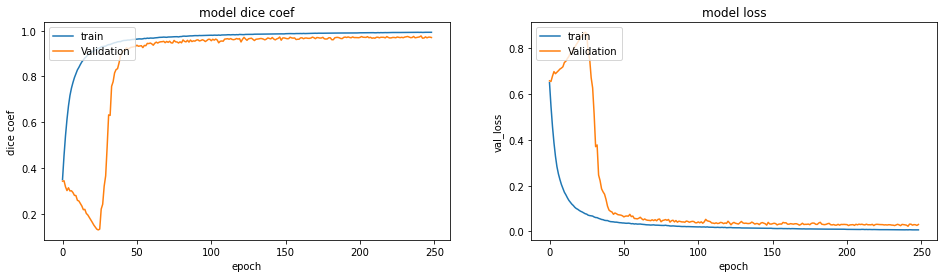

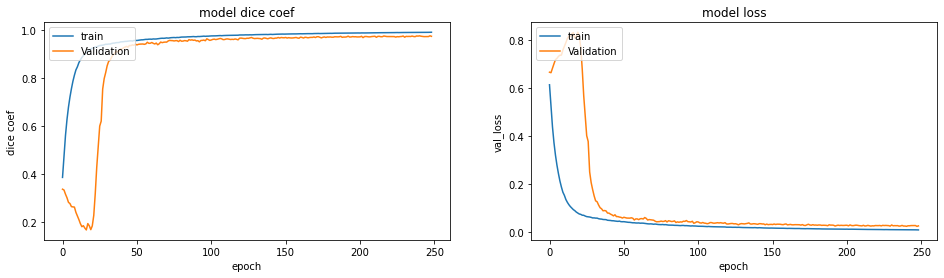

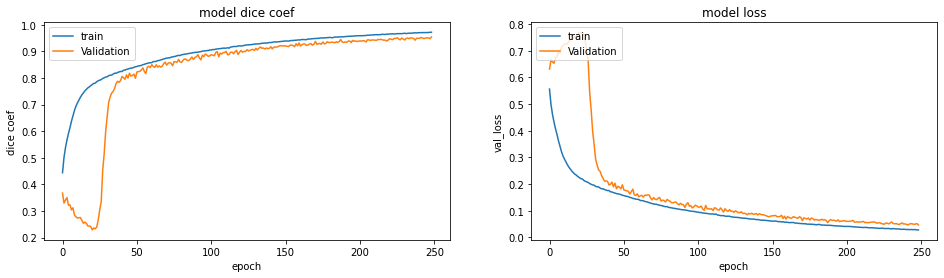

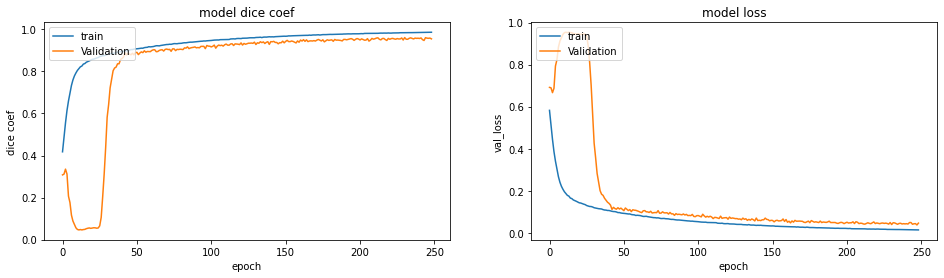

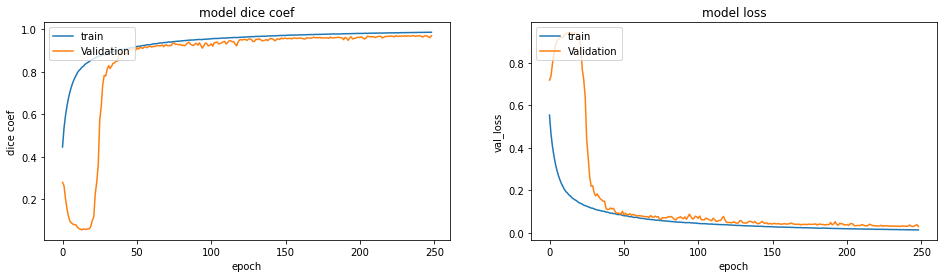

In [5]:
import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau 
from keras import backend as K

import matplotlib.pyplot as plt
import gc

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

#=================================Start kfold validations and model build+train+evaluations==========
num_train_samples = 88
train_batch_size = 8
train_steps = np.ceil(num_train_samples / train_batch_size)

num_val_samples = 22
val_batch_size = 4
val_steps = np.ceil(num_val_samples / val_batch_size)

#==============================================DATA AUGMENTATION=========================================
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output

dg_args = dict(   rescale=1., 
                  rotation_range = 10, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.8, 1.2],  
                  fill_mode = 'nearest',
                  data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)

def gen_augmented_pairs(in_cxr, in_seg, batch_size):
    while True:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_cxr = image_gen.flow(in_cxr, batch_size = batch_size, seed = seed)
        g_seg = image_gen.flow(in_seg, batch_size = batch_size, seed = seed)
        for i_cxr, i_seg in zip(g_cxr, g_seg):
            yield i_cxr, i_seg

def get_model_name(k):
    return 'UNET_EFFNETB7_'+str(k)+'.h5'
    
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []

#save_dir = '/kaggle/working/'
num_folds=5
kf = KFold(n_splits=num_folds, shuffle=True)
fold_var = 0
Y = np.arange(0,CXR_train.shape[0])
countfold=0

for train_index, val_index in kf.split(Y):
    countfold += 1
    print("Running FOLD number ", countfold)
    
    train_gen = gen_augmented_pairs(CXR_train[train_index], seg_train[train_index], batch_size = train_batch_size)
    image_gen = ImageDataGenerator(rescale=1.)
    valid_gen = gen_augmented_pairs(CXR_train[val_index], seg_train[val_index], batch_size = val_batch_size)
    
    #Build Model
    K.clear_session()
    model = UEfficientNet(input_shape=input_shape,dropout_rate=0.0)
    # Build model
    opt = Adam(learning_rate=0.0001)    #0.0001 with 150 epochs with dropout 0.0 is currently best working
    model.compile(loss=dice_loss, optimizer=opt, metrics=[dice_coef])

    # CREATE CALLBACKS
    checkpoint = ModelCheckpoint(get_model_name(fold_var), monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=50, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
    early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=50) 
    callbacks_list = [checkpoint, early, reduceLROnPlat]

    # FIT THE MODEL	
    history = model.fit_generator(train_gen, 
                  steps_per_epoch = train_steps,
                  epochs = 250, verbose=1,
                  validation_data = valid_gen,
                  validation_steps = val_steps,
                  callbacks = callbacks_list
                 )

    # Plot train and validation iou metric curves

    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['dice_coef'][1:])
    plt.plot(history.history['val_dice_coef'][1:])
    plt.ylabel('dice coef')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')

    plt.title('model dice coef')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.title('model loss')
    gc.collect()

    del model 
    fold_var += 1

In [6]:
def Dice(y_true, y_pred):
    """Returns Dice Similarity Coefficient for ground truth and predicted masks."""
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    return (2. * intersection + 1.) / (y_true.sum() + y_pred.sum() + 1.)

def masked(img, gt, mask, alpha=1):
    """Returns image with GT lung field outlined with red, predicted lung field
    filled with blue.""" 
    rows, cols = img.shape
    color_mask = np.zeros((rows, cols, 3))
    #convert to numpy float and then subtract
    #boundary = morphology.dilation(gt, morphology.disk(3)) - gt
    a1 = morphology.dilation(gt, morphology.disk(3))
    a2 = gt
    a1 = a1.astype(np.float32)
    a2 = a2.astype(np.float32)
    boundary = a1 - a2
    
    color_mask[mask == 1] = [1, 0, 0]         #predicted mask - Red color area
    color_mask[boundary == 1] = [0, 0, 1]     # Actual mask - Ground truth - Blue curve
    img_color = np.dstack((img, img, img))

    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(img_hsv)
    return img_masked

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

In [7]:
from skimage import morphology, color, io, exposure
import cv2

n_test = CXR_test.shape[0]
dices = np.zeros(n_test)
im_shape = (256, 256)

#del model
K.clear_session()
input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
model = UEfficientNet(input_shape=input_shape,dropout_rate=0.0)
# Build model
opt = Adam(learning_rate=0.0001)    
model.compile(loss=dice_loss, optimizer=opt, metrics=[dice_coef])
              
i=0
count=0
for xx in range(len(CXR_test)):
    count=count+1
    img = CXR_test[xx]
    img = img[np.newaxis,...]
    
    model.load_weights('./UNET_EFFNETB7_0.h5')
    pred0 = model.predict(img)[..., 0].reshape(input_shape[:2])
    model.load_weights('./UNET_EFFNETB7_1.h5')
    pred1 = model.predict(img)[..., 0].reshape(input_shape[:2])    
    model.load_weights('./UNET_EFFNETB7_2.h5')
    pred2 = model.predict(img)[..., 0].reshape(input_shape[:2]) 
    model.load_weights('./UNET_EFFNETB7_3.h5')
    pred3 = model.predict(img)[..., 0].reshape(input_shape[:2])     
    model.load_weights('./UNET_EFFNETB7_4.h5')
    pred4 = model.predict(img)[..., 0].reshape(input_shape[:2]) 
                  
    pred = (pred0 + pred1 + pred2 + pred3 + pred4)/5.0
    
    img = cv2.cvtColor(CXR_test[xx], cv2.COLOR_BGR2GRAY)
    
    yy = CXR_Mask_test[xx]
    mask = yy[..., 0].reshape(input_shape[:2])
    
    # Binarize masks
    gt = mask > 0.5
    pr = pred > 0.5

    # Remove regions smaller than 2% of the image
    pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))

    #io.imsave('./'+str(count), masked(img, gt, pr, 1))
    export_path = '../working/'
    image_filename = str(count) + str('.png')
    io.imsave(os.path.join(export_path, image_filename), masked(img, gt, pr, 1)) 

    dices[i] = Dice(gt, pr)
    print(str(count), dices[i])

    i += 1
    if i == n_test:
        break
        
print('Mean Dice:', dices.mean())

(None, 16, 16, 1344)
(None, 32, 32, 480)
(None, 64, 64, 288)
(None, 128, 128, 192)
1 0.9856567616024454
2 0.9841098224231701
3 0.9839496536247438
4 0.9861729769858946
5 0.9825254189857281
6 0.9711168923313428
7 0.9840351285332093
8 0.982691286281126
9 0.9828028969616528
10 0.9738827787832383
11 0.9863535315739661
12 0.9874373538255931
13 0.9819261498596416
14 0.966830090393749
15 0.9862781197859732
16 0.9824819200737603
17 0.9798721686476789
18 0.9726437699680511
19 0.9783413992949752
20 0.976594778660613
21 0.952783229513326
22 0.9805129240710824
23 0.981010045410761
24 0.9817845978971299
25 0.9873077050868857
26 0.9785018154022549
27 0.972124360326073
28 0.9822433379339632
Mean Dice: 0.9797132469370723
